# Object Detection

In this notebook I will be using the powerful YOLOv3 model to detect objects. Many of the ideas in this notebook are described in the YOLO v3 paper: Redmon et al., 2018 (https://arxiv.org/abs/1804.02767). THe particular model I will be using is YOLO trained on the COCO dataset.

THe COCO dataset consits of 80 labels, including, but not limited to:

* People
* Bicycles
* Cars and Trucks
* Airplanes
* Stop Signs and Fire Hydrants
* Animals, including cats, dogs, birds, horses, cows, and sheep, to name a few
* Kitchen and dining objects, such as wine glasses, cups, forks, knives, spoons, etx. 
* ...and much more!

You can find a full list of what YOLO trained on the COCO dataset can detect using this link (https://github.com/pjreddie/darknet/blob/master/data/coco.names).

**Objective**:
- Use object detection on a car detection dataset
- Deal with bounding boxes
- Use object dection on various objects

### Steps to Accomplish This:
1. Define path to image we will train on and configuration files relevant to YOLO model (This step requires user input)
2. Define Labels, colors for bounding boxes, and load YOLOv3 along with it's pretrained weights
3. Load images and send through network
4. Calculate object bounding boxes
5. Apply non-max suppression to overlapping bounding boxes
6. Display Image with Bouding Boxes

In [1]:
# Import the required packages
import numpy as np
import argparse
import time
import cv2
import os

In [2]:
#Function to request paths for image to train on and necessary YOLO model configuration files
def enter_required_paths():
    
    image_path = input("Base path to Image we will train on ")
    yolo_labels_path = input("Base path to YOLO stored labels , looking for coco.names ")
    yolo_weights_path = input("Base path to YOLO pretrained weights, looking for yolov3.weights ")
    yolo_config_path = input("Base path to YOLO configuration file, looking for yolov3.cfg ")
    
    return image_path,yolo_labels_path,yolo_weights_path,yolo_config_path

In [25]:
#Initialize rrequired paths
image_path,yolo_labels_path,yolo_weights_path,yolo_config_path = enter_required_paths()

Base path to Image we will train on /home/mohammad/Documents/Deeplearning_ai/Projects/Object Detection/images/soccer.jpg
Base path to YOLO stored labels , looking for coco.names yolo-coco/coco.names
Base path to YOLO pretrained weights, looking for yolov3.weights yolo-coco/yolov3.weights
Base path to YOLO configuration file, looking for yolov3.cfg yolo-coco/yolov3.cfg


In [ ]:
Base path to Image we will train on /home/mohammad/Documents/Deeplearning_ai/Projects/Object Detection/images/baggage_claim_2.jpg
Base path to YOLO stored labels , looking for coco.names yolo-coco/coco.names
Base path to YOLO pretrained weights, looking for yolov3.weights yolo-coco/yolov3.weights
Base path to YOLO configuration file, looking for yolov3.cfg yolo-coco/yolov3.cfg

### Define Labels, colors for bounding boxes, and load YOLOv3 along with it's pretrained weights

In [26]:
#Define path to label, read file and store labels in 'LABELS'
labelsPath = os.path.abspath(yolo_labels_path)
classLabels = open(labelsPath).read().strip().split("\n")

# # initialize a list of colors to represent each possible class label
np.random.seed(42)
classColors = np.random.randint(0,255, size=(len(classLabels),3),dtype="uint8")

In [27]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.abspath(yolo_weights_path)
configPath = os.path.abspath(yolo_config_path)
 
# load our YOLO object detector trained on COCO dataset (80 classes).
#Using OpenCV's DNN function called cv2.dnn.readNetFromDarknet
print("Loading YOLOv3 from disk...")
yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

Loading YOLOv3 from disk...


### Load images and send through network

In [28]:
# load our input image and grab its spatial dimensions (Don't need depth)
image = cv2.imread(image_path)
(H, W) = image.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln_outer_names = yolo_net.getUnconnectedOutLayersNames()

# ln = net.getLayerNames()
# ln_outer_names = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities

#OpenCV assumes images are in BGR channel order, however, the mean value assumes we are using RGB order.
#To solve this discrepancy we can swap the R and B channels  using swapRB=True
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB = True, crop =False)

#Initiate forward pass through our YOLO network and show inference time. 

#setInput sets the input to the pre-trained YOLO model
yolo_net.setInput(blob)
start = time.time()
layerOutputs = yolo_net.forward(ln_outer_names)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.399854 seconds


### Side note on what blob[cv2.dnn.blobFromImage] is
In context of deep learning and image classification, preprocessing taks normally involve:
* Mean subtraction
* Scaling by some factor

OpenCV's new deep neural network (dnn) module contains two functions that can be used for preprocessing images and preparing them for classificaiton via pre-trained deep learning models

There are two image preprocessing images from OpenCV
* cv2.dnn.blobFromImage
* cv2.dnn.blobFromImages

These two functions perform 
1. Mean subtraction
2. Scaling
3. Optionally channel swapping

Before beginning to train our network, we first compute the average pixel intensity across all images in the training set for each of the Red, Green, and Blue Channels resulting in MuR,MuG,MuB

The pixel-wise method is often used for larger datasets

When we are ready to pass an image through our network (whether for training or testing), we subtract the mean Mu,from each input channel of the input image

* R = R - MuR
* G = G - MuG
* B = B - MuB

We also ave a scaling factor sigma, which add in a normalization, sigma can be standard deviation across the training set (turning the preprocessing step into a standard score/z-score)

* R = R - MuR/Sigma
* G = G - MuG/Sigma
* B = B - MuB/Sigma


Now onto blobFromImages

blobFromImage creates 4-dimensional blobs from an image. Optionally resizes and crops images from the center, subtracts mean values, scales values by scalefactor, swap Blue and Red Channels


### Visualize output of our Model

In [29]:
# initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [30]:
minimum_probability = float(input("Please Enter Probability Threshold, typically '.5' "))

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the weightss
    for weights in output:
        # extract the class ID and confidence (i.e., probability) of the current object weights
        scores = weights[5:]
        
        #Maximum classID present in scores
        classID = np.argmax(scores)

        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > minimum_probability:
            # Scale the bounding box coordinates back relative to the size of the image.
            #YOLO returns the center (x,y) coordinates of the bounding box followed by the boxes'
            #width and height
            box = weights[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            #To find x and y intercept subtract width and heigh from center x,y coordinates
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

Please Enter Probability Threshold, typically '.5' .5


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="images/anchor_map.png" style="width:200px;height:200;">
Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression.

### Note on Non-Max  Suppression
The way NMS works is :
* It first discards all those cells where probability of object being present (calculated in final softmax layer) is <= probability threshold
* Then it takes the cell with largest probability among candidates for object as a prediction
* Finally we discard any remaining cell with Intersection over union value >= 0.5 with the prediction cell.

In [31]:
#Apply non-maxima suppression inorder to supress weak, overlapping bouding boxes to prevent
idxs = cv2.dnn.NMSBoxes(boxes, confidences, .5,.3)

In [32]:
#Let’s draw the boxes and class text on the image!
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
 
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in classColors[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classLabels[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
 
# Save the image to file
file_name = input("Name of trained image, 'Example: car_trained.jpg' with bounded boxes? To be save to images folder:  ")
trained_image = cv2.imwrite("./images/"+file_name,image)


Name of trained image, 'Example: car_trained.jpg' with bounded boxes? To be save to images folder:  soccer_trained.jpg


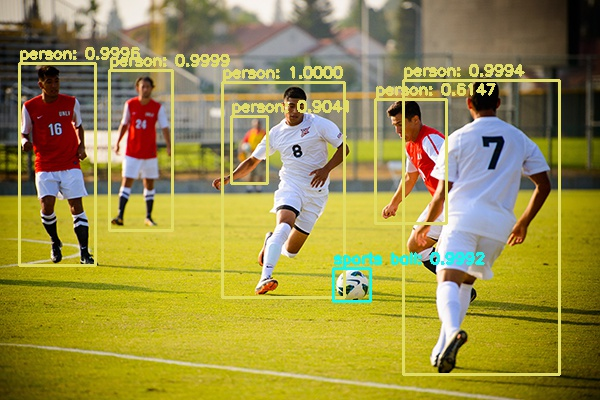

In [33]:
from IPython.display import Image
Image("./images/"+file_name) 